In [1]:
# Import Libraries
import torch
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_scheduler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

In [2]:
# Mounting Google Drive to access files stored in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Prepare Dataset
class SentimentDataset(Dataset):
  def __init__(self, texts, labels):
    self.texts = texts.reset_index(drop=True)
    self.labels = labels.reset_index(drop=True)

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    encodings = tokenizer(self.texts[idx], truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    return encodings['input_ids'].squeeze(), encodings['attention_mask'].squeeze(), torch.tensor(self.labels[idx])

# Create Evaluation Function
def evaluate(model, data_loader):
  model.eval()  # Set the model to evaluation mode
  all_labels = []
  all_predictions = []
  with torch.no_grad():  # Disable gradient computation
    for batch in data_loader:
      input_ids, attention_mask, labels = batch
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      labels = labels.to(device)
      # Forward pass
      outputs = model(input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      predictions = torch.argmax(logits, dim=1)
      # Append labels and predictions for metric calculation
      all_labels.extend(labels.cpu().numpy())
      all_predictions.extend(predictions.cpu().numpy())

    # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
    # Print Results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    # Confusion matrix for DistilBERT
    textblob_cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
    sns.heatmap(textblob_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
    plt.title("Fine-Tuned DistilBERT Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    return

# Create Training Function
def train(model, optimizer, data_loader, lr_scheduler):
  model.train()
  for batch in data_loader:
    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    # Backward pass
    loss.backward()
    # Optimizer step and scheduler update
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
  print(f"Training Loss: {loss.item()}")

In [4]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/NLP_Project/IMDB_Dataset_Preprocessed.csv')
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [5]:
# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42)

print("Training set size:", train_df.shape)
print("Testing set size:", test_df.shape)

train_dataset = SentimentDataset(train_df['cleaned_review'], train_df['sentiment'])
test_dataset = SentimentDataset(test_df['cleaned_review'], test_df['sentiment'])

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

Training set size: (25000, 20)
Testing set size: (25000, 20)


In [7]:
# Load Pretrained Model and Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
# Set Up Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 5
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
# Move model to GPU Available
device = torch.device("cuda")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Training Loss: 0.27221548557281494
Accuracy: 0.9047
Precision: 0.8934
Recall: 0.9193
F1 Score: 0.9062


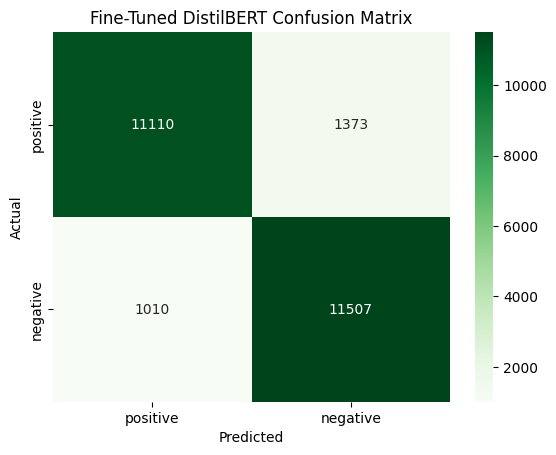

Training Loss: 0.05833638831973076
Accuracy: 0.9072
Precision: 0.9115
Recall: 0.9023
F1 Score: 0.9069


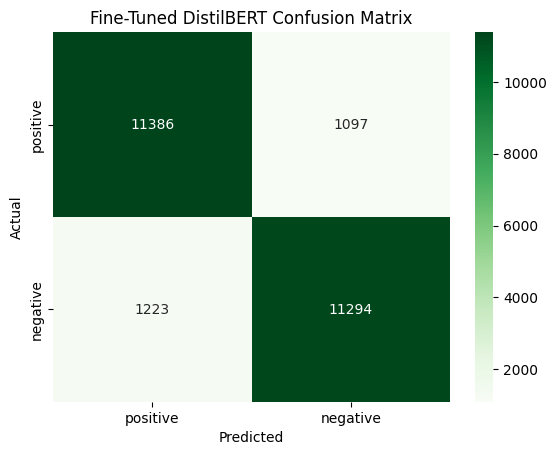

Training Loss: 0.06635604798793793
Accuracy: 0.9012
Precision: 0.9232
Recall: 0.8754
F1 Score: 0.8987


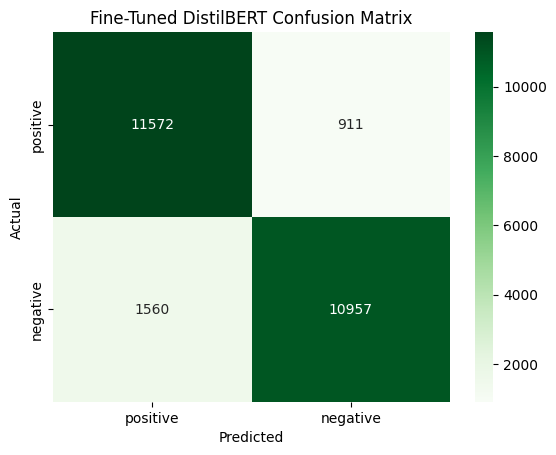

Training Loss: 0.050673287361860275
Accuracy: 0.9043
Precision: 0.8875
Recall: 0.9263
F1 Score: 0.9065


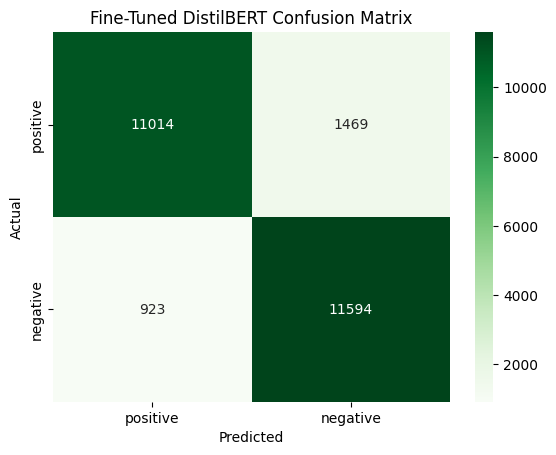

Training Loss: 0.00139738735742867
Accuracy: 0.9064
Precision: 0.9032
Recall: 0.9105
F1 Score: 0.9069


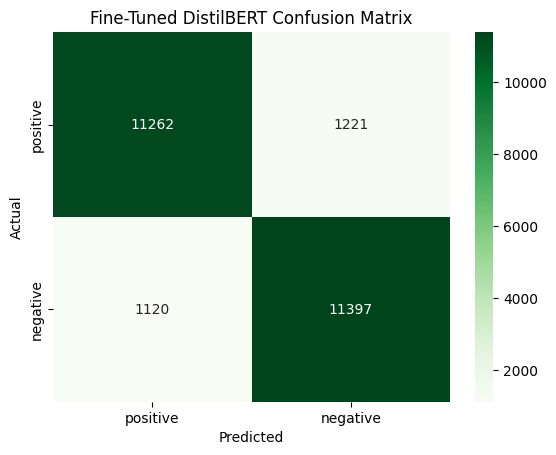

In [8]:
# Train and Test Model
for epoch in range(num_epochs):
  train(model, optimizer, train_loader, lr_scheduler)
  evaluate(model, test_loader)
  # Save the Fine-Tuned Model
  model.save_pretrained("/content/drive/MyDrive/NLP_Project/fine_tuned_distilbert")
  tokenizer.save_pretrained("/content/drive/MyDrive/NLP_Project/fine_tuned_distilbert")